# Analisi e implementazione
### Long Short Term Memory Networks for Anomaly Detection in Time Series

Questo sezione progetta e analizza "Malhotra, Pankaj & Vig, Lovekesh & Shroff, Gautam & Agarwal, Puneet. (2015). Long Short Term Memory Networks for Anomaly Detection in Time Series.". Questo lavoro propone di usare una LSTM addestrata a prevedere l'andamento del giorno successivo e di usare la differenza tra la sequenza prevista e quella reale per ottenere un vettore di errori (vettore dei residui). I vettori dei residui vengono poi usati per calcolare la media e la covarianza per stimare la distribuzione gaussiana corrispettiva. In seguito viene trovata una soglia per separare i dati anomali da quelli normali massimizzando $F_{0.1}$. Inoltre, abbiamo osservato che se invece di usare la likelihood della distribuzione si usa la norma Lp del vettore dei residui è possibile ottenere risultati migliori. <br>
Il dataset è stati separato nel seguente modo:
* Training: Usato per addestrare la rete neurale (contiene solo dati non anomali)
* Test: Usato per valutare il risultato finale (contiene sia dati anomali che normali)
* Validation 1: Usato per early stop e stima di media e varianza (contiene solo dati non anomali)
* Validation 2: Usato per trovare la soglia ottimale (contiene sia dati anomali che normali)

In [99]:
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import tensorflow.keras.layers as layers
from sklearn.model_selection import KFold
import scipy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval, rand
import seaborn as sns
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.preprocessing import QuantileTransformer, quantile_transform, PowerTransformer, power_transform, robust_scale, minmax_scale
from pingouin import multivariate_normality
import gc
from scipy.signal import savgol_filter

## Parametri
In questa sezione definiamo i parametri e le costanti utili.

In [100]:
DAY = 12
BATCH_SIZE = 512
WINDOW_OFFSET = DAY * 1
WINDOW_SIZE = DAY * 14
WINDOW_SEEN = DAY * 7
FIG_SIZE = (16, 10)
HYPERTUNE = False

## Funzioni Utili

In [101]:
def get_windows(x, win_in=WINDOW_SIZE, win_off=WINDOW_OFFSET, skip=8):
    x = x[::skip]
    y = np.vstack([x[i+win_off:i+win_in+win_off] for i in range(len(x)-win_in-win_off)])
    x = np.vstack([x[i:i+win_in] for i in range(len(x)-win_in-win_off)])
    x = np.expand_dims(x, axis=-1)
    y = np.expand_dims(y, axis=-1)
    return x, y

In [102]:
def get_model(units=[40, 30], dropout_rate=0.1, inp_noise=0.0, inp_dropout=0.0, loss='mse', recurrent='lstm', lr=1e-2, dense_activation='sigmoid', hidden_unit=1, ensemble=1):
    inp = layers.Input(shape=(None, 1))
    x = inp
    base = x
    
    if recurrent != 'none':
        recurrent_layer = {
            'gru': layers.GRU,
            'lstm': layers.LSTM,
            'rnn': layers.SimpleRNN,
        }[recurrent]
        ans = 0
        x = base
        for i in range(ensemble):
            x = tf.keras.layers.GaussianNoise(inp_noise)(x)
            x = tf.keras.layers.Dropout(inp_dropout)(x)

            for unit in units:
                x = recurrent_layer(unit, return_sequences=True)(x)
                x = layers.Dropout(dropout_rate)(x)
                if dense_activation != 'zero':
                    x = layers.Dense(unit)(x)
                    x = layers.Activation(dense_activation)(x)


            x = layers.Dense(1)(x)
            ans += x
        ans /= ensemble
        x = ans
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(lr)
    loss = {'mse':'mse',
         'mae':'mae',
         'mape': 'mape',
         'robust':tfa.losses.pinball_loss
    }[loss]
    model.compile(opt, loss, metrics=['mse', 'mape', 'mae'])
    return model


In [103]:
def run(x, holidays, params={}, verbose=1, batch_size=BATCH_SIZE, maxpos=WINDOW_SEEN):
    if 'rob_cov' in params:
        rob_cov = params['rob_cov']
        del params['rob_cov']
    else:
        rob_cov = False
        
    x = np.clip(x, np.percentile(x, 5), np.percentile(x, 95))
    x = minmax_scale(x.reshape(-1, 1)).flatten()
    
    print(len(holidays[holidays == 0]), len(holidays[holidays == 1]))
    
    x, y = get_windows(x)
    x_cnt = np.arange(len(x))
    x_holidays, y_holidays = get_windows(holidays)
    x_holidays = np.squeeze(x_holidays)
    y_holidays = np.squeeze(y_holidays)
    
    # split sets
    cond = ((x_holidays == 1).any(-1))|((y_holidays == 1).any(-1))
    x_anom = x[cond]
    x_noanom = x[~cond]
    y_anom = y[cond]
    y_noanom = y[~cond]
    cnt_anom = x_cnt[cond]
    cnt_noanom = x_cnt[~cond]
    
    good_split = [0.45, 0.625, 0.75]
    anomaly_split = [0.45]
    good_int = [int(len(x_noanom)*a) for a in good_split]
    anomaly_int = [int(len(x_anom)*a) for a in anomaly_split]
    x_train, x_val1, x_val2, x_test = np.split(x_noanom, good_int)
    y_train, y_val1, y_val2, y_test = np.split(y_noanom, good_int)
    cnt_train, cnt_val1, cnt_val2, cnt_test = np.split(cnt_noanom, good_int)

    x_aval2, x_atest = np.split(x_anom, anomaly_int)
    y_aval2, y_atest = np.split(y_anom, anomaly_int)
    cnt_aval2, cnt_atest = np.split(cnt_anom, anomaly_int)

    x_val2 = np.concatenate([x_val2, x_aval2])
    y_val2 = np.concatenate([y_val2, y_aval2])
    cnt_val2 = np.concatenate([cnt_val2, cnt_aval2])

    x_test = np.concatenate([x_test, x_atest])
    y_test = np.concatenate([y_test, y_atest])
    cnt_test = np.concatenate([cnt_test, cnt_atest])
    
    print('x_train:', x_train.shape)
    print('x_val1:', x_val1.shape)
    print('x_val2:', x_val2.shape)
    print('x_test:', x_test.shape)
    
    # fit
    model = get_model(**params)
    hist = model.fit(x_train, y_train,
             batch_size=batch_size,
             epochs=1000,
             verbose = verbose,
             validation_data=(x_val1, y_val1),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25, restore_best_weights=True),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, verbose=True)
    ]).history
    
    # postprocess
    def gen_ans(x_curr, y_curr, cnt_curr):
        ans = [[] for i in range(len(x) + 2*WINDOW_SIZE)]
        ans_pred = [[] for i in range(len(x) + 2*WINDOW_SIZE)]
        ans_curr = [[] for i in range(len(x) + 2*WINDOW_SIZE)]
        y_pred = model.predict(x_curr)
        
        for off, win_pred, win_curr in zip(cnt_curr, y_pred, y_curr):
            for p0, (val_pred, val_curr) in enumerate(zip(win_pred, win_curr)):
                ans[off + p0].append(val_pred[0] - val_curr[0])
                ans_pred[off + p0].append(val_pred[0])
                ans_curr[off + p0].append(val_curr[0])
        
        pos = [i for i in range(len(ans)) if len(ans[i]) >= maxpos]
        ans = [v[:maxpos] for v in ans if len(v) >= maxpos]
        ans_pred = [v[:maxpos] for v in ans_pred if len(v) >= maxpos]
        ans_curr = [v[:maxpos] for v in ans_curr if len(v) >= maxpos]
        
        return np.array(pos), np.array(ans), np.array(ans_pred), np.array(ans_curr)

    pos_train, ans_train, pred_train, curr_train = gen_ans(x_train, y_train, cnt_train)
    pos_val1, ans_val1, pred_val1, curr_val1 = gen_ans(x_val1, y_val1, cnt_val1)
    pos_val2, ans_val2, pred_val2, curr_val2 = gen_ans(x_val2, y_val2, cnt_val2)
    pos_test, ans_test, pred_test, curr_test = gen_ans(x_test, y_test, cnt_test)
    
    
    assert len(holidays) // 8 > pos_test.max() + WINDOW_OFFSET, f'{len(holidays) // 8} < {pos_test.max() + WINDOW_OFFSET}'
    assert pos_test.min() >= 0, f'{pos_test.min()} < 0'
    assert len(holidays) // 8 > pos_val2.max() + WINDOW_OFFSET, f'{len(holidays) // 8} < {pos_val2.max() + WINDOW_OFFSET}'
    assert pos_test.min() >= 0, f'{pos_val2.min()} < 0'
    
    holi_test = holidays[::8][pos_test + WINDOW_OFFSET]
    holi_val2 = holidays[::8][pos_val2 + WINDOW_OFFSET]
    
    assert holidays[::8][pos_train + WINDOW_OFFSET].sum() == 0
    assert holidays[::8][pos_val1  + WINDOW_OFFSET].sum() == 0
    assert holi_test.sum() > 0
    assert holi_val2.sum() > 0
    
    print('holi_test:', holi_test.sum())
    print('holi_val2:', holi_test.sum())
    
    if rob_cov:
        mcd = MinCovDet(support_fraction=0.8).fit(ans_val1)
    else:
        mcd = EmpiricalCovariance().fit(ans_val1)
    
    mean = mcd.location_
    cov = mcd.covariance_
    
    ans = {}
    for h in hist:
        ans[h] = min(hist[h])
    ans['mean'] = mean
    ans['cov'] = cov
    ans['res_train'] = ans_train
    ans['res_test'] = ans_test
    ans['res_val1'] = ans_val1
    ans['res_val2'] = ans_val2
    ans['holidays_val2'] = holi_val2
    ans['holidays_test'] = holi_test
    ans['y_train_pred'] = pred_train
    ans['y_test_pred'] = pred_test
    ans['y_val1_pred'] = pred_val1
    ans['y_val2_pred'] = pred_val2
    ans['y_train'] = curr_train
    ans['y_test'] = curr_test
    ans['y_val1'] = curr_val1
    ans['y_val2'] = curr_val2
    ans['cnt_train'] = pos_train
    ans['cnt_test'] = pos_test
    ans['cnt_val1'] = pos_val1
    ans['cnt_val2'] = pos_val2

    return ans

In [104]:
def conv2week(cnts, y_true, y_pred):
    f_valid = False
    for dx in range(7):
        conta = np.zeros(max(cnts))
        holi_score = np.zeros(max(cnts))
        pred_score = np.zeros(max(cnts))
        for cnt, val, p in zip(cnts, y_true, y_pred):
            cnt = (cnt + dx) // 7
            conta[cnt] += 1
            holi_score[cnt] += val
            pred_score[cnt] += p
        week_used = conta > 1
        holi_score = holi_score[week_used] / conta[week_used]
        pred_score = pred_score[week_used] / conta[week_used]
        if len(holi_score[(holi_score>1e-9)&(holi_score<1-1e-9)]) == 0:
            f_valid = True
        if f_valid:
            break
            
    return (holi_score > 0.5).astype('int8'), pred_score, (pred_score > 0).astype('int8')


def print_results(ans, use_val=True, print_resp=True, distance_metric=2):
    
    if use_val:
        res_thresh = ans['res_val2']
        holidays_thresh = ans['holidays_val2']        
        cnt_thresh = ans['cnt_val2']
    else:
        res_thresh = ans['res_test']
        holidays_thresh = ans['holidays_test']
        cnt_thresh = ans['cnt_test']
    
    if distance_metric == 'prob':
        prob = scipy.stats.multivariate_normal.pdf(res_thresh, mean=ans['mean'], cov=ans['cov'], allow_singular=True)
        prob[~np.isfinite(prob)] = 1e300
    else:
        prob = np.linalg.norm(res_thresh, axis=1, ord=distance_metric)
    
    threshold = 0
    threshold_i = -1
    bestf0_1 = 0
    prob_sorted = np.sort(prob.copy())
    best_conf_matrix = -1
    step = len(prob_sorted)
    for i in range(step):
        p = prob_sorted[i]
        y_pred = (prob > p).astype('int8')
        if distance_metric == 'prob':
            y_pred = 1 - y_pred
        y_true, y_prob, y_pred = conv2week(cnt_thresh, holidays_thresh, y_pred)
        f0_1 = metrics.fbeta_score(y_true, y_pred, beta=0.1)
        if bestf0_1 < f0_1:
            bestf0_1 = f0_1
            threshold = p
            threshold_i = i
    
    if distance_metric == 'prob':
        prob = scipy.stats.multivariate_normal.pdf(ans['res_test'], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
        prob[~np.isfinite(prob)] = 1e300
    else:
        prob = np.linalg.norm(ans['res_test'], axis=1, ord=distance_metric)
    y_pred = (prob > threshold).astype('int8')
    if distance_metric == 'prob':
        y_pred = 1 - y_pred
    
    y_true, y_prob, y_pred = conv2week(ans['cnt_test'], ans['holidays_test'], y_pred)
    
    f0_1 = metrics.fbeta_score(y_true, y_pred, beta=0.1)
    acc = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    auc = metrics.roc_auc_score(y_true, y_pred)

    cm = pd.DataFrame(metrics.confusion_matrix(y_true, y_pred))

    cm.index.name = 'Reale'
    cm.columns.name = 'Previsto'
    resp = {}
    resp['auc'] = auc
    resp['f0.1'] = f0_1
    resp['accuracy'] = acc
    resp['recall'] = recall
    resp['precision'] = precision
    resp['threshold'] = threshold
    resp['cm'] = cm

    if print_resp:
        print(f'threshold: {threshold} ({threshold_i}/{len(prob_sorted)}) - f0.1: {f0_1} - f0.1(validation): {bestf0_1}')
        print({name:resp[name] for name in resp if name not in ['threshold', 'f0.1', 'cm']})
        print()
        print(metrics.classification_report(y_true, y_pred))
        fig, axs = plt.subplots(figsize=(16, 8), ncols=2)

        sns.heatmap(cm, cmap="Blues", annot=True,annot_kws={"size": 16}, ax=axs[0])
        prec, recall, _ = metrics.precision_recall_curve(y_true, y_prob)
        pr_display = metrics.PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=axs[1])
        plt.show()

    if not print_resp:
        return resp

In [105]:
def parse_params(params):
    params['units'] = []
    params['ensemble'] = int(params['ensemble'])
    for i in range(3):
        if i < params['n_layers']:
            params['units'].append(int(params[f'unit_{i}']))
        del params[f'unit_{i}']
    del params['n_layers']
    del params['batch_size']
    del params['distance_metric']
    del params['maxpos']
    return params

df_x, df_y = [], []
def objective(params):
    global df_y, df_x
    real_params = params.copy()
    
    batch_size = int(2**params['batch_size'])
    distance_metric = params['distance_metric']
    maxpos = int(params['maxpos'])
    
    params = parse_params(params)
    ans0 = run(df_x, df_y, params=params, batch_size=batch_size, verbose=0, maxpos=maxpos)
    ans0 = print_results(ans0, print_resp=False, distance_metric=distance_metric)
    if ans0['f0.1'] > 0.3:
        ans1 = run(df_x, df_y, params=params, batch_size=batch_size, verbose=0, maxpos=maxpos)
        ans1 = print_results(ans1, print_resp=False, distance_metric=distance_metric)
    else:
        ans1 = ans0.copy()
    score = -ans0['f0.1']-ans1['f0.1']
    
    print(real_params, params)
    print(score, ans0, ans1)
    
    return score

space = {'n_layers':hp.quniform('n_layers', 1, 3, 1),
         'unit_0':hp.quniform('unit_0', 32, 256, 1),
         'unit_1':hp.quniform('unit_1', 32, 128, 1),
         'unit_2':hp.quniform('unit_2', 4, 64, 1),
         'batch_size':hp.uniform('batch_size', 7, 7.1),
         'dropout_rate':hp.uniform('dropout_rate', 0.0, 0.7), 
         'hidden_unit': hp.quniform('hidden_unit', 64, 256, 1),
         'inp_noise':hp.uniform('inp_noise', 0.0, 0.1),
         'inp_dropout':hp.uniform('inp_dropout', 0.0, 0.1),
         'ensemble': hp.quniform('ensemble', 1, 5, 1),
         'dense_activation': hp.choice('dense_activation', ['swish']),
         'loss':hp.choice('loss', ['mse']),
         'recurrent':hp.choice('recurrent', ['lstm']),
         'distance_metric': hp.choice('distance_metric', [2]),
         'maxpos': hp.quniform('maxpos', WINDOW_SIZE - 2 * DAY, WINDOW_SIZE - 1 * DAY, 1),
}

# Paesi Bassi

In [106]:
df = pd.read_pickle('train2.pkl').astype('int32')
df

,x,holidays
0,950,1
1,939,1
2,943,1
3,971,1
4,1014,1
...,...,...
35035,622,1
35036,614,1
35037,627,1
35038,633,1


In [107]:
if HYPERTUNE:
    df_x, df_y = df['x'].to_numpy(), df['holidays'].to_numpy()
    best = fmin(objective, space, algo=tpe.suggest, max_evals=40)
else:
    best = None
gc.collect()
best

In [108]:
params = {'dense_activation': 'swish', 
          'dropout_rate': 0.2, 
          'ensemble': 5, 
          'hidden_unit': 160, 
          'inp_dropout': 0.3, 
          'inp_noise': 0.0, 
          'loss': 'mse', 
          'recurrent': 'lstm', 
          'units': [50]
}


In [109]:
ans = run(df['x'].to_numpy(), df['holidays'].to_numpy(), params=params)

30336 4704
x_train: (1421, 168, 1)
x_val1: (553, 168, 1)
x_val2: (863, 168, 1)
x_test: (1363, 168, 1)
Epoch 1/1000
3/3 [==============================] - 3s 855ms/step - loss: 0.1610 - mse: 0.1610 - mape: 10364614.0000 - mae: 0.2939 - val_loss: 0.0726 - val_mse: 0.0726 - val_mape: 1944213.5000 - val_mae: 0.2247
Epoch 2/1000
3/3 [==============================] - 0s 161ms/step - loss: 0.0973 - mse: 0.0973 - mape: 18753292.0000 - mae: 0.2557 - val_loss: 0.0688 - val_mse: 0.0688 - val_mape: 2302387.5000 - val_mae: 0.2348
Epoch 3/1000
3/3 [==============================] - 0s 162ms/step - loss: 0.0910 - mse: 0.0910 - mape: 22858366.0000 - mae: 0.2642 - val_loss: 0.0608 - val_mse: 0.0608 - val_mape: 1791385.8750 - val_mae: 0.1987
Epoch 4/1000
3/3 [==============================] - 0s 160ms/step - loss: 0.0819 - mse: 0.0819 - mape: 20273374.0000 - mae: 0.2346 - val_loss: 0.0522 - val_mse: 0.0522 - val_mape: 2275184.5000 - val_mae: 0.1955
Epoch 5/1000
3/3 [==============================] - 0s

In [110]:
for metric, val_metric in [('mse', 'val_mse'), ('mae', 'val_mae'), ('mape', 'val_mape')]:
    print(f"{metric.rjust(8)}: {str(round(ans[metric], 3)).rjust(8)} - {str(round(ans[val_metric], 3)).rjust(8)}")

     mse:    0.023 -    0.015
     mae:    0.106 -    0.087
    mape: 6983792.0 - 376497.188


## Analisi della distribuzione del residuo
In questa sezione verifica se la distribuzione del residuo (la differenza tra il valore reale e il valore predetto).<br>
Possiamo osservare che tutti i test statistici effettuati (Henze-Zirkler, Kolmogorov-Smirnov, D’Agostino-Pearson) concludono che la distribuzione dei residui non sia gaussiana (p-value minore di $10^{-10}$).

In [111]:
# normality test
def avg_pval(x):
    v = [multivariate_normality(np.random.default_rng().choice(x, size=10, axis=0), alpha=.05).pval for _ in range(200)]
    v = [i for i in v if not np.isnan(i)]
    return np.mean(v)

# Henze-Zirkler test
print('ans_train:', multivariate_normality(ans['res_train'], alpha=0.5), avg_pval(ans['res_train']))
print('ans_val1:', multivariate_normality(ans['res_val1'], alpha=0.5), avg_pval(ans['res_val1']))
print('ans_val2:', multivariate_normality(ans['res_val2'], alpha=0.5), avg_pval(ans['res_val2']))
print('ans_test:', multivariate_normality(ans['res_test'], alpha=0.5), avg_pval(ans['res_test']))
print()

args = (ans['mean'], ans['cov'], True, int(5e4))
# Kolmogorov-Smirnov test
print('ans_train:', scipy.stats.kstest(np.random.default_rng().choice(ans['res_train'], size=150, axis=0), scipy.stats.multivariate_normal.cdf, N=10, args=args))
print('ans_val1:', scipy.stats.kstest(np.random.default_rng().choice(ans['res_val1'], size=150, axis=0), scipy.stats.multivariate_normal.cdf, N=10, args=args))
print('ans_val2:', scipy.stats.kstest(np.random.default_rng().choice(ans['res_val2'], size=150, axis=0), scipy.stats.multivariate_normal.cdf, N=10, args=args))
print('ans_test:', scipy.stats.kstest(np.random.default_rng().choice(ans['res_test'], size=150, axis=0), scipy.stats.multivariate_normal.cdf, N=10, args=args)) 

C:\Users\Lorenzo Rossi\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Lorenzo Rossi\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ans_train: HZResults(hz=37.15794434501417, pval=nan, normal=False) nan
ans_val1: HZResults(hz=5.149954535064386, pval=nan, normal=False) nan
ans_val2: HZResults(hz=61.579651011355345, pval=nan, normal=False) nan
ans_test: HZResults(hz=93.98305669431684, pval=nan, normal=False) nan

ans_train: KstestResult(statistic=0.9995581151119597, pvalue=0.0)
ans_val1: KstestResult(statistic=0.9647897615062313, pvalue=2.001589465512418e-218)
ans_val2: KstestResult(statistic=0.9721878998590481, pvalue=8.631726336929771e-234)
ans_test: KstestResult(statistic=0.9622792356900521, pvalue=6.139070077731045e-214)


In [112]:
# D’Agostino-Pearson test
for idx, (res_train, res_test) in enumerate(zip(ans['res_train'].T, ans['res_test'].T)):
    print(f'{idx} - training set: {scipy.stats.normaltest(res_train).pvalue} test set: {scipy.stats.normaltest(res_test).pvalue}')


0 - training set: 3.741558925825141e-14 test set: 3.660142504230649e-110
1 - training set: 3.871800593048541e-14 test set: 4.4494908078259905e-110
2 - training set: 3.67016757477044e-14 test set: 4.3225026587948815e-110
3 - training set: 3.3891248486101584e-14 test set: 3.050902921738371e-110
4 - training set: 3.163230769494119e-14 test set: 2.399490328598175e-110
5 - training set: 3.0929206299754836e-14 test set: 2.5151327635990032e-110
6 - training set: 2.9401703502348356e-14 test set: 6.836724470477052e-111
7 - training set: 2.9628500648121305e-14 test set: 1.2307769759510112e-110
8 - training set: 3.218131696802887e-14 test set: 2.2067641190344694e-110
9 - training set: 3.646043785750529e-14 test set: 1.4748096044987872e-110
10 - training set: 3.857923858050497e-14 test set: 7.47869476212479e-111
11 - training set: 3.9549412260352136e-14 test set: 4.7718690870087844e-111
12 - training set: 4.1378180964239587e-14 test set: 6.463512472281024e-111
13 - training set: 3.8692493375628284

### Istogramma dei residui per istante
Nelle celle successive possiamo osservare come si comporta il residuo in diversi istanti di tempo e set.
In particolare possiamo osservare come i set val2 e test abbiano una distribuzione con code molto più lunghe rispetto ai set senza anomalie (val1 e training)

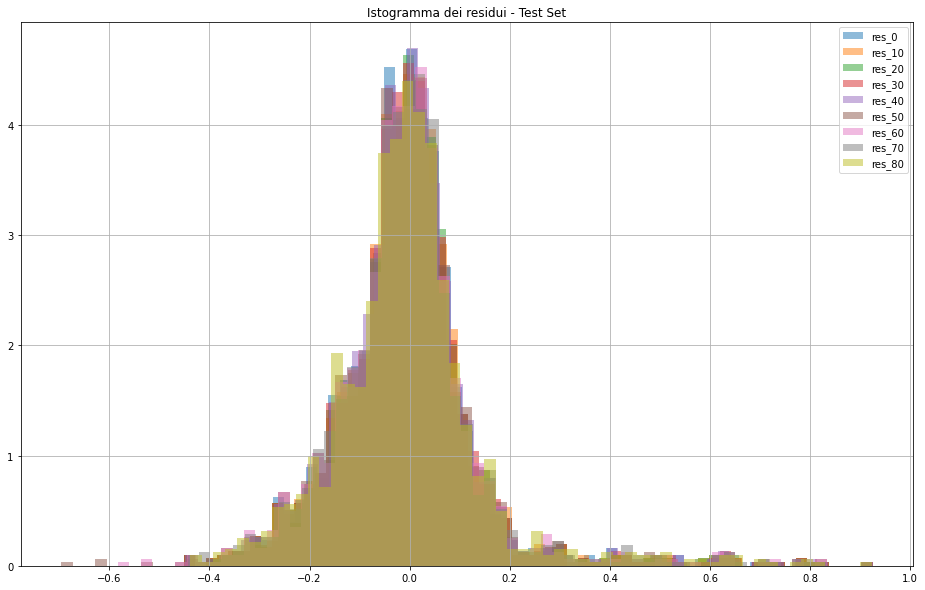

In [113]:
#res plot val1
fig, ax = plt.subplots(ncols=1, figsize=FIG_SIZE)
for i in range(0, ans['res_test'].shape[-1], 10):
    ax.hist([b[i] for b in ans['res_test']], label=f'res_{i}', bins='auto', density=True, alpha=0.5)
ax.set_title('Istogramma dei residui - Test Set')
ax.grid()
ax.legend()
plt.show()

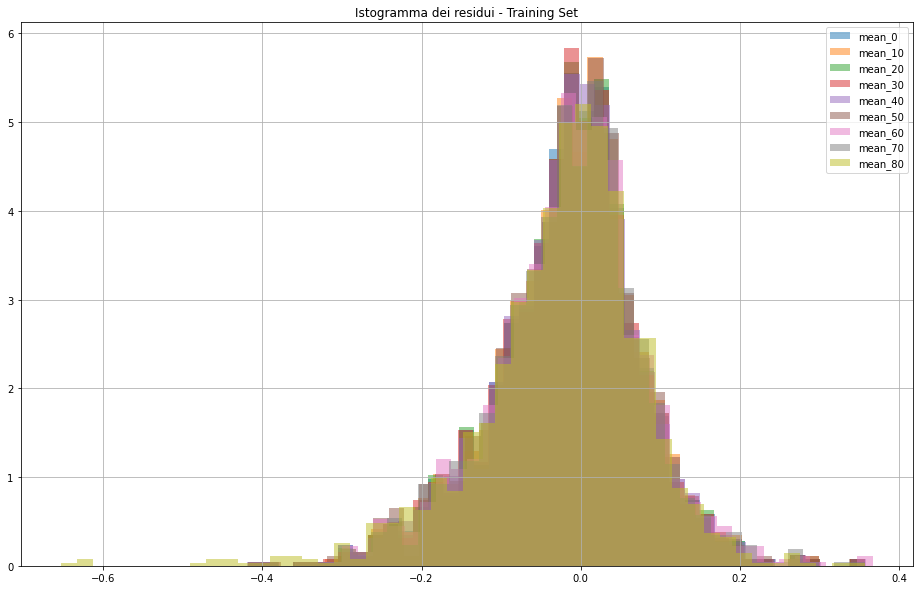

In [114]:
#res plot training
fig, ax = plt.subplots(ncols=1, figsize=FIG_SIZE)
for i in range(0, ans['res_train'].shape[-1], 10):
    ax.hist([b[i] for b in ans['res_train']], label=f'mean_{i}', bins='auto', density=True, alpha=0.5)
ax.set_title('Istogramma dei residui - Training Set')
ax.grid()
ax.legend()
plt.show()

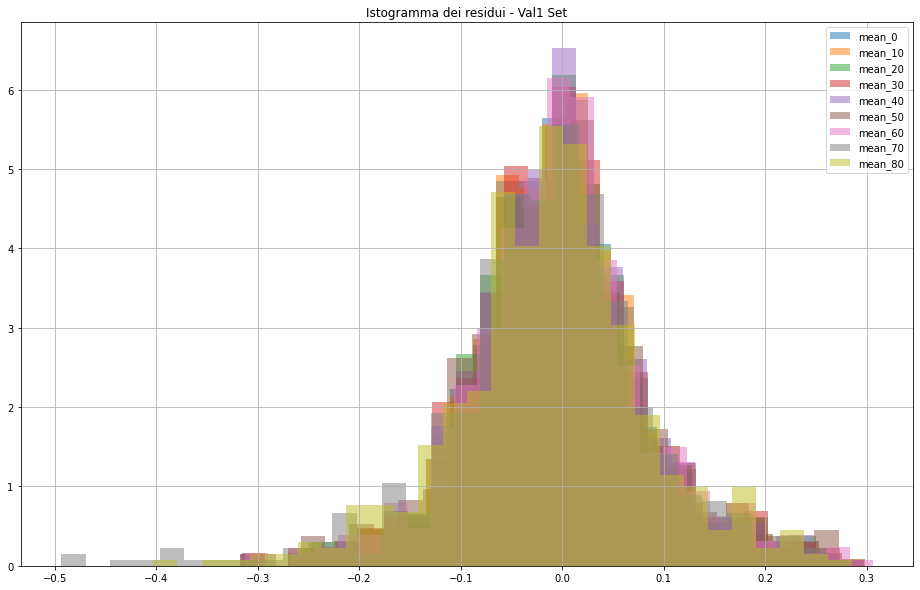

In [115]:
#res plot val1
fig, ax = plt.subplots(ncols=1, figsize=FIG_SIZE)
for i in range(0, ans['res_val1'].shape[-1], 10):
    ax.hist([b[i] for b in ans['res_val1']], label=f'mean_{i}', bins='auto', density=True, alpha=0.5)
ax.set_title('Istogramma dei residui - Val1 Set')
ax.grid()
ax.legend()
plt.show()

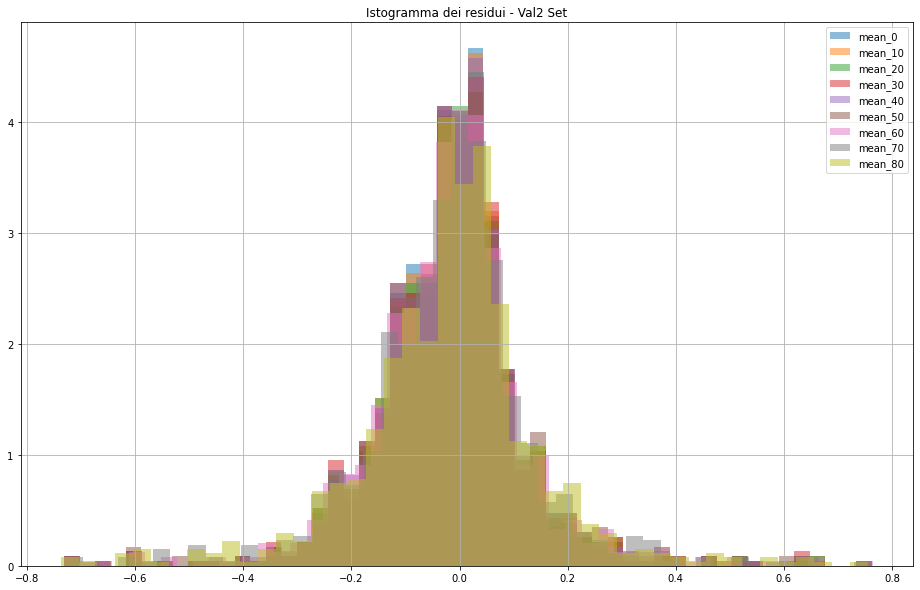

In [116]:
#res plot val2
fig, ax = plt.subplots(ncols=1, figsize=FIG_SIZE)
for i in range(0, ans['res_val2'].shape[-1], 10):
    ax.hist([b[i] for b in ans['res_val2']], label=f'mean_{i}', bins='auto', density=True, alpha=0.5)
ax.set_title('Istogramma dei residui - Val2 Set')
ax.grid()
ax.legend()
plt.show()

### Media e covarianza del residuo

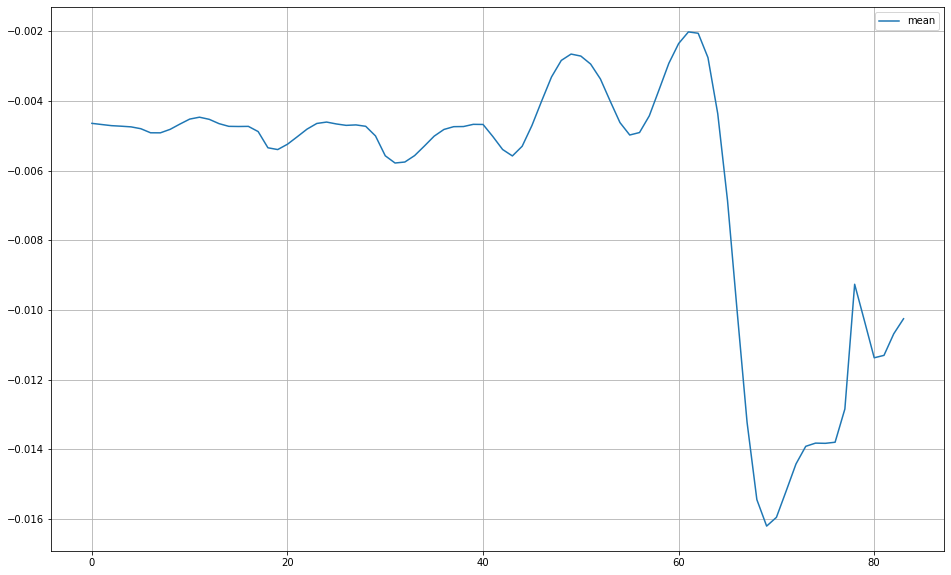

In [117]:
#mean graph
fig, ax = plt.subplots(ncols=1, figsize=FIG_SIZE)
ax.plot(ans['mean'], label=f'mean')
ax.grid()
ax.legend()
plt.show()

rank: 84/84
det: 0.0
min(eigvals): 2.322510239363367e-10


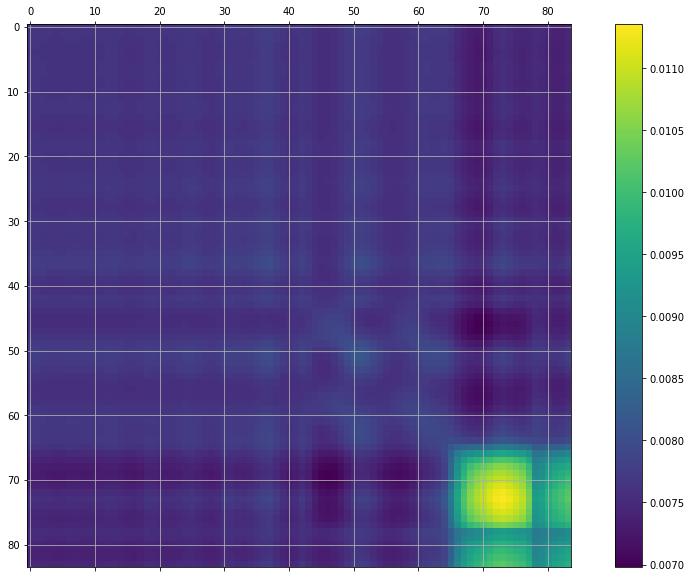

In [118]:
#convariance matrix

print(f'rank: {np.linalg.matrix_rank(ans["cov"])}/{len(ans["cov"])}')
print(f'det: {np.linalg.det(ans["cov"])}')
print(f'min(eigvals): {np.min(np.linalg.eigvals(ans["cov"]))}')

fig, ax = plt.subplots(figsize=FIG_SIZE)
cax = ax.matshow(ans['cov'])
ax.grid()
cbar = fig.colorbar(cax)
plt.show()

### Confronta tra giorni normali e giorni anomali

Nei grafici sottostanti possiamo osservare come la distribuzione dei residui sia diversa tra quella dei giorni normali e quella dei giorni anomali.

In [122]:
## Kolmogorov-Smirnov statistic on 2 samples
print('test (L2):  ', scipy.stats.ks_2samp(np.linalg.norm(ans['res_test'][ans['holidays_test'] == 0], axis=1, ord=2), 
                                         np.linalg.norm(ans['res_test'][ans['holidays_test'] == 1], axis=1, ord=2)))
print('test (prob):', scipy.stats.ks_2samp(scipy.stats.multivariate_normal.pdf(ans['res_test'][ans['holidays_test'] == 0], mean=ans['mean'], cov=ans['cov'], allow_singular=True),
                                           scipy.stats.multivariate_normal.pdf(ans['res_test'][ans['holidays_test'] == 1], mean=ans['mean'], cov=ans['cov'], allow_singular=True))) 
print('val2 (L2):  ', scipy.stats.ks_2samp(np.linalg.norm(ans['res_val2'][ans['holidays_val2'] == 0], axis=1, ord=2), 
                                    np.linalg.norm(ans['res_val2'][ans['holidays_val2'] == 1], axis=1, ord=2)))
print('val2 (prob):', scipy.stats.ks_2samp(scipy.stats.multivariate_normal.pdf(ans['res_val2'][ans['holidays_val2'] == 0], mean=ans['mean'], cov=ans['cov'], allow_singular=True),
                                           scipy.stats.multivariate_normal.pdf(ans['res_val2'][ans['holidays_val2'] == 1], mean=ans['mean'], cov=ans['cov'], allow_singular=True)))

test (L2):   Ks_2sampResult(statistic=0.1677209068399876, pvalue=4.656047282391995e-06)
test (prob): Ks_2sampResult(statistic=0.37074435159393376, pvalue=2.220446049250313e-16)
val2 (L2):   Ks_2sampResult(statistic=0.1130298273155416, pvalue=0.06121769969490909)
val2 (prob): Ks_2sampResult(statistic=0.15790162218733647, pvalue=0.0022934851520379773)


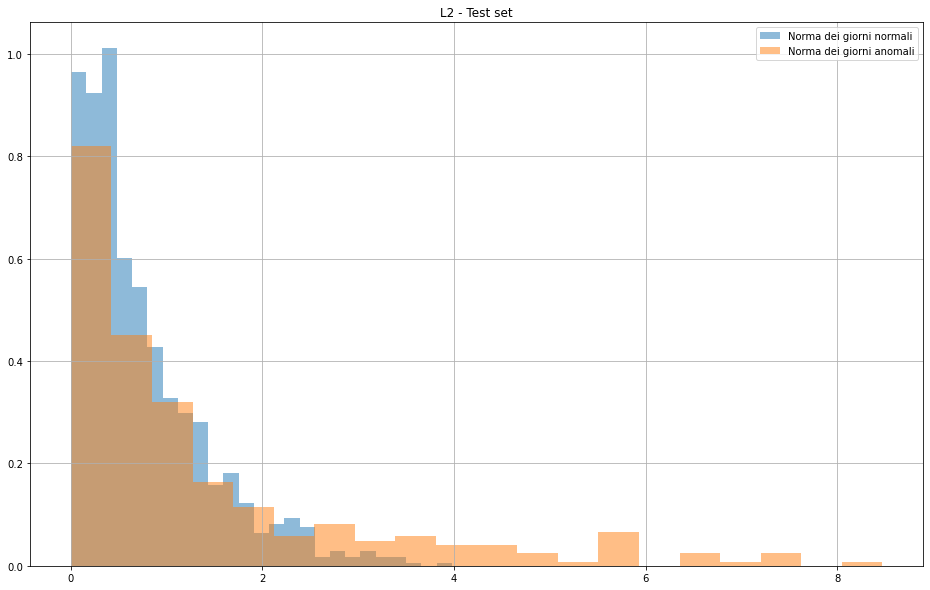

In [123]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
prob_normaldays = np.linalg.norm(ans['res_test'][ans['holidays_test'] == 0], axis=1, ord=2) 
prob_holidays = np.linalg.norm(ans['res_test'][ans['holidays_test'] == 1], axis=1, ord=2)

ax.hist(prob_normaldays, label='Norma dei giorni normali', bins='auto', density=True, alpha=0.5)
ax.hist(prob_holidays, label='Norma dei giorni anomali', bins='auto', density=True, alpha=0.5)

ax.grid()
ax.legend()
ax.set_title('L2 - Test set')
plt.show()

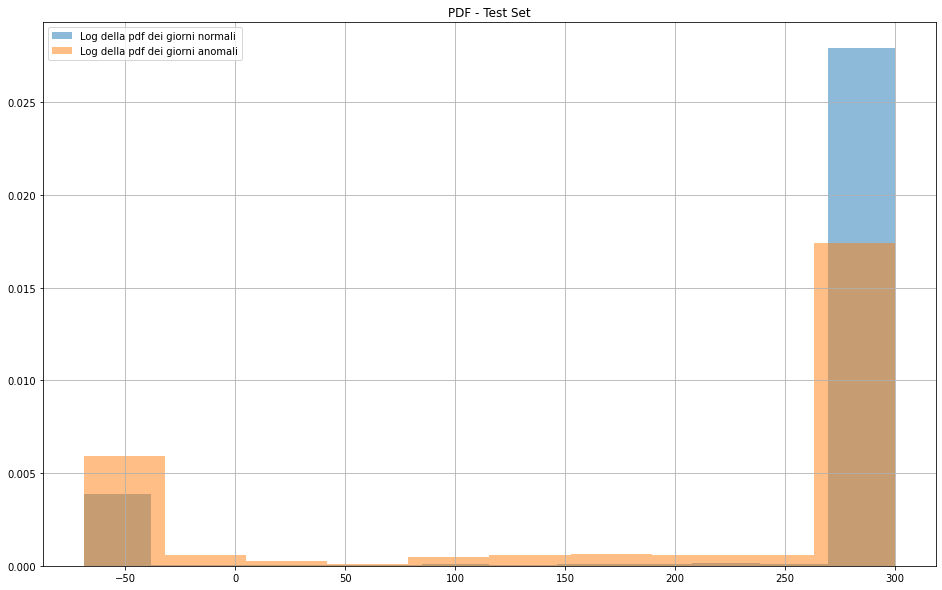

In [124]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
prob_normaldays = scipy.stats.multivariate_normal.pdf(ans['res_test'][ans['holidays_test'] == 0], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob_holidays = scipy.stats.multivariate_normal.pdf(ans['res_test'][ans['holidays_test'] == 1], mean=ans['mean'], cov=ans['cov'], allow_singular=True)

ax.hist(np.clip(np.log(prob_normaldays+1e-30), -100, 300), label='Log della pdf dei giorni normali', bins='auto', density=True, alpha=0.5)
ax.hist(np.clip(np.log(prob_holidays+1e-30), -100, 300), label='Log della pdf dei giorni anomali', bins='auto', density=True, alpha=0.5)

ax.grid()
ax.legend()
ax.set_title('PDF - Test Set')
plt.show()

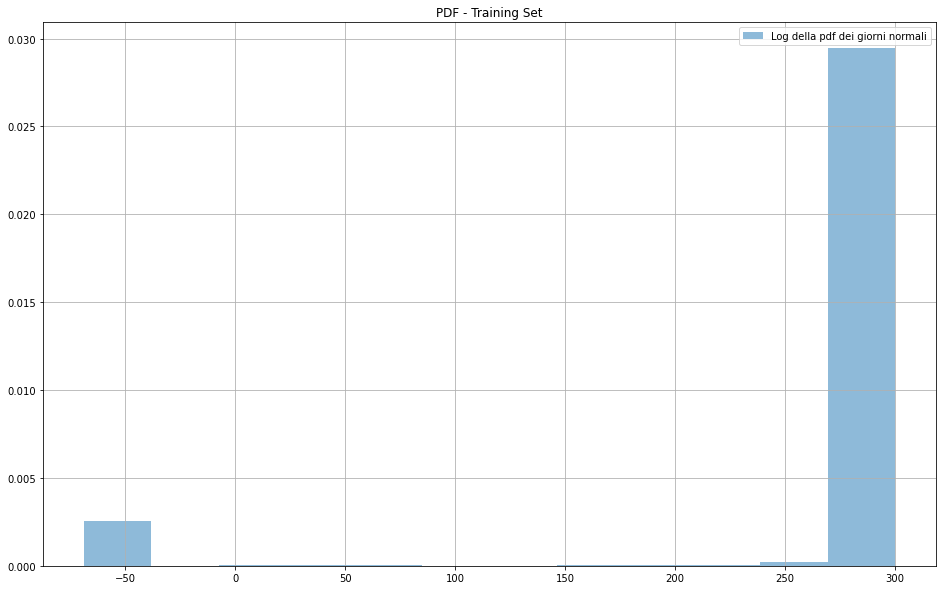

In [125]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
prob_normaldays = scipy.stats.multivariate_normal.pdf(ans['res_train'], mean=ans['mean'], cov=ans['cov'], allow_singular=True)

ax.hist(np.clip(np.log(prob_normaldays+1e-30), -100, 300), label='Log della pdf dei giorni normali', bins='auto', density=True, alpha=0.5)

ax.grid()
ax.legend()
ax.set_title('PDF - Training Set')
plt.show()

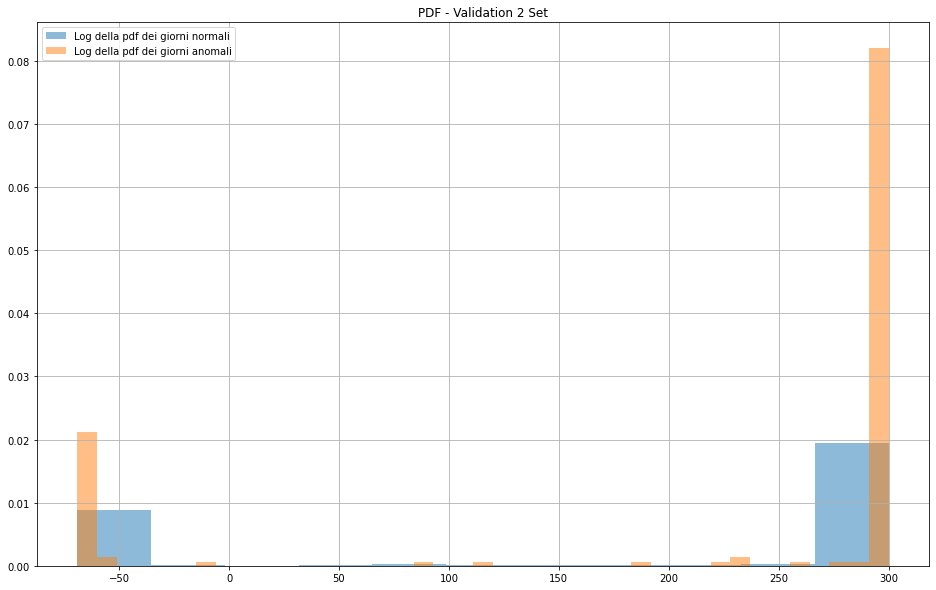

In [126]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
prob_normaldays = scipy.stats.multivariate_normal.pdf(ans['res_val2'][ans['holidays_val2'] == 0], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob_holidays = scipy.stats.multivariate_normal.pdf(ans['res_val2'][ans['holidays_val2'] == 1], mean=ans['mean'], cov=ans['cov'], allow_singular=True)

ax.hist(np.clip(np.log(prob_normaldays+1e-30), -100, 300), label='Log della pdf dei giorni normali', bins='auto', density=True, alpha=0.5)
ax.hist(np.clip(np.log(prob_holidays+1e-30), -100, 300), label='Log della pdf dei giorni anomali', bins='auto', density=True, alpha=0.5)

ax.grid()
ax.legend()
ax.set_title('PDF - Validation 2 Set')
plt.show()

In [127]:
best_idx = np.argmin(abs(ans['mean']))
best_idx, np.argsort(abs(ans['mean']))

(61,
 array([61, 62, 60, 49, 50, 63, 48, 59, 51, 47, 52, 58, 46, 53, 64, 57, 11,
        10, 12, 24, 54,  0, 23, 13, 25,  9, 39, 40,  1, 27, 26, 45,  2,  3,
        28, 14, 16, 15, 38, 37,  4,  5, 22,  8, 36, 17, 56,  6,  7, 55, 29,
        35, 41, 21, 20, 34, 44, 18, 42, 19, 33, 30, 43, 32, 31, 65, 78, 66,
        83, 79, 82, 81, 80, 77, 67, 76, 74, 75, 73, 72, 71, 68, 70, 69],
       dtype=int64))

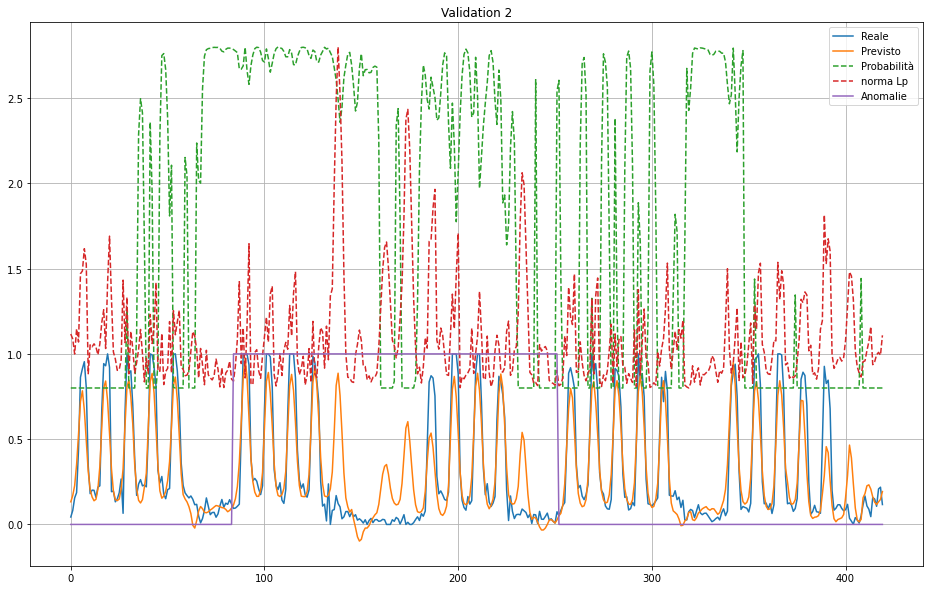

In [128]:
## val2 data
lower = DAY * 0
upper = lower + DAY * 35
pos = ans['cnt_val2'][lower:upper]
fig, ax = plt.subplots(figsize=FIG_SIZE)

ax.plot([i[best_idx] for i in ans['y_val2'][lower:upper]], label='Reale')
ax.plot([i[best_idx] for i in ans['y_val2_pred'][lower:upper]], label='Previsto')

prob = scipy.stats.multivariate_normal.pdf(ans['res_val2'][lower:upper], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob[~np.isfinite(prob)] = 1e300
prob = np.log(prob + 1e-30)
prob_test = prob.copy()

prob = 2 * (prob - prob_test.min()) / (prob_test.max() - prob_test.min())
prob = prob + 0.8
ax.plot(prob, label='Probabilità', linestyle='dashed')

prob = np.linalg.norm(ans['res_val2'][lower:upper], axis=1)
norm_test = prob.copy()
prob = 2 * (prob - norm_test.min()) / (norm_test.max() - norm_test.min())
prob = prob + 0.8
ax.plot(prob, label='norma Lp', linestyle='dashed')


ax.plot(ans['holidays_val2'][lower:upper], label='Anomalie', alpha=1.0)

ax.grid()
ax.legend(loc='upper right')
ax.set_title('Validation 2')
plt.show()

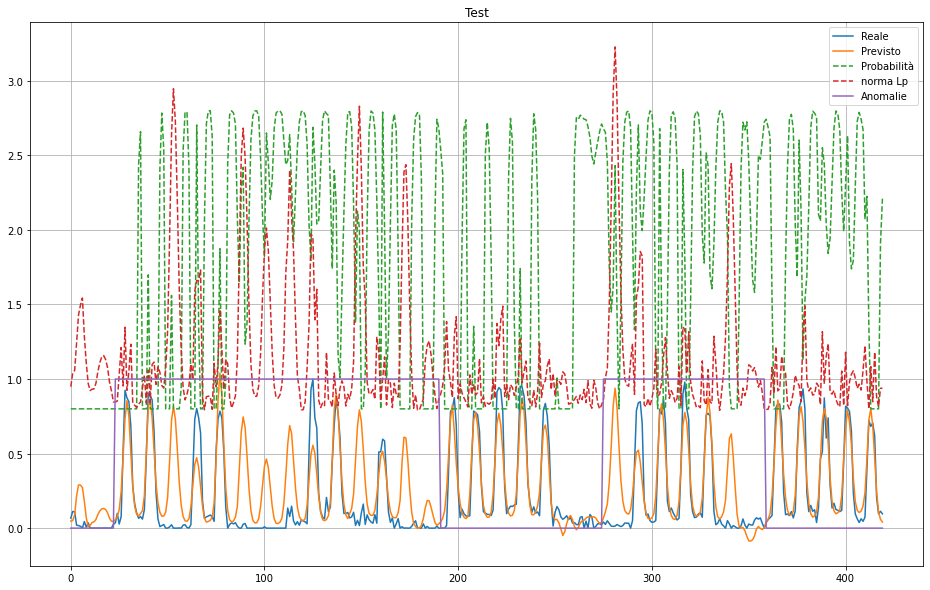

In [129]:
## test data
lower = DAY * 0
upper = lower + DAY * 35
pos = ans['cnt_test'][lower:upper]
fig, ax = plt.subplots(figsize=FIG_SIZE)

ax.plot([i[best_idx] for i in ans['y_test'][lower:upper]], label='Reale')
ax.plot([i[best_idx] for i in ans['y_test_pred'][lower:upper]], label='Previsto')

prob = scipy.stats.multivariate_normal.pdf(ans['res_test'][lower:upper], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob[~np.isfinite(prob)] = 1e300
prob = np.log(prob + 1e-30)

prob = 2 * (prob - prob_test.min()) / (prob_test.max() - prob_test.min())
prob = prob + 0.8
ax.plot(prob, label='Probabilità', linestyle='dashed')

prob = np.linalg.norm(ans['res_test'][lower:upper], axis=1)
prob = 2 * (prob - norm_test.min()) / (norm_test.max() - norm_test.min())
prob = prob + 0.8
ax.plot(prob, label='norma Lp', linestyle='dashed')


ax.plot(ans['holidays_test'][lower:upper], label='Anomalie', alpha=1.0)

ax.grid()
ax.legend(loc='upper right')
ax.set_title('Test')
plt.show()

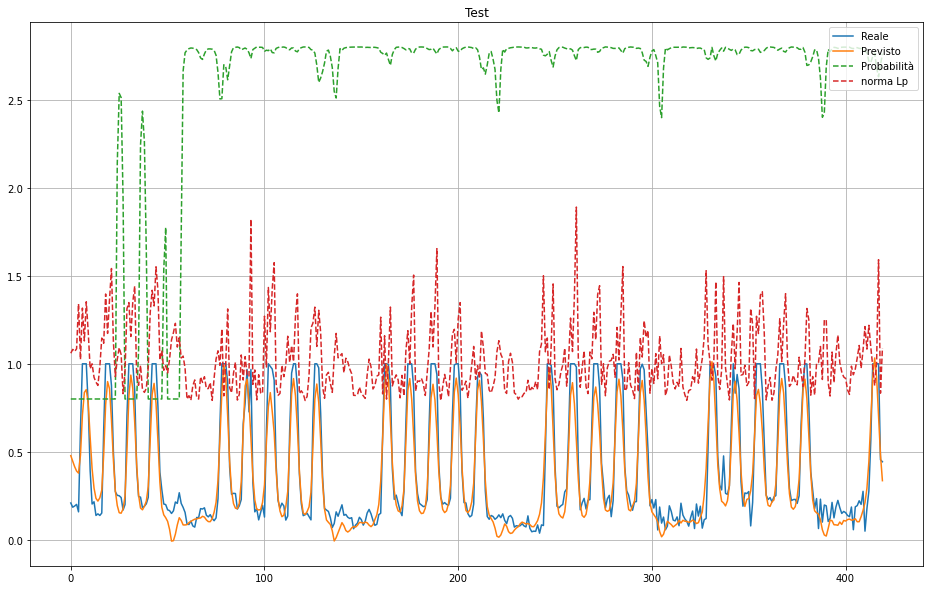

In [130]:
## train data
lower = DAY * 0
upper = lower + DAY * 35
pos = ans['cnt_train'][lower:upper]
fig, ax = plt.subplots(figsize=FIG_SIZE)

ax.plot([i[best_idx] for i in ans['y_train'][lower:upper]], label='Reale')
ax.plot([i[best_idx] for i in ans['y_train_pred'][lower:upper]], label='Previsto')

prob = scipy.stats.multivariate_normal.pdf(ans['res_train'][lower:upper], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob[~np.isfinite(prob)] = 1e300
prob = np.log(prob + 1e-30)

prob = 2 * (prob - prob_test.min()) / (prob_test.max() - prob_test.min())
prob = prob + 0.8
ax.plot(prob, label='Probabilità', linestyle='dashed')

prob = np.linalg.norm(ans['res_train'][lower:upper], axis=1)
prob = 2 * (prob - norm_test.min()) / (norm_test.max() - norm_test.min())
prob = prob + 0.8
ax.plot(prob, label='norma Lp', linestyle='dashed')

ax.grid()
ax.legend(loc='upper right')
ax.set_title('Test')
plt.show()

threshold: 1.2484547222785028e+189 (329/805) - f0.1: 0.43591895456180313 - f0.1(validation): 0.2516119577960141
{'auc': 0.7874114870180959, 'accuracy': 0.7346938775510204, 'recall': 0.8780487804878049, 'precision': 0.43373493975903615}

              precision    recall  f1-score   support

           0       0.96      0.70      0.81       155
           1       0.43      0.88      0.58        41

    accuracy                           0.73       196
   macro avg       0.69      0.79      0.69       196
weighted avg       0.85      0.73      0.76       196



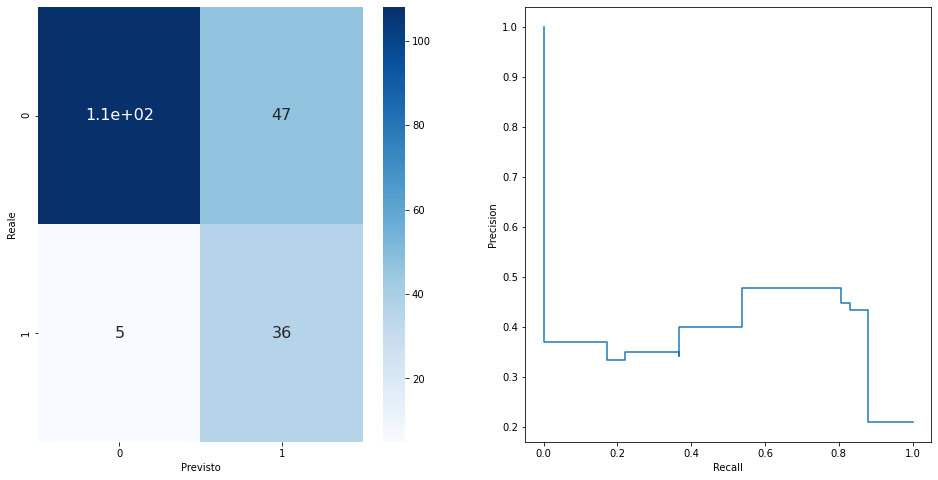

In [131]:
# Probabilità
print_results(ans, True, distance_metric='prob')

threshold: 6.71145398411907 (803/805) - f0.1: 0.9160997732426304 - f0.1(validation): 0.8145161290322581
{'auc': 0.5487804878048781, 'accuracy': 0.8112244897959183, 'recall': 0.0975609756097561, 'precision': 1.0}

              precision    recall  f1-score   support

           0       0.81      1.00      0.89       155
           1       1.00      0.10      0.18        41

    accuracy                           0.81       196
   macro avg       0.90      0.55      0.54       196
weighted avg       0.85      0.81      0.74       196



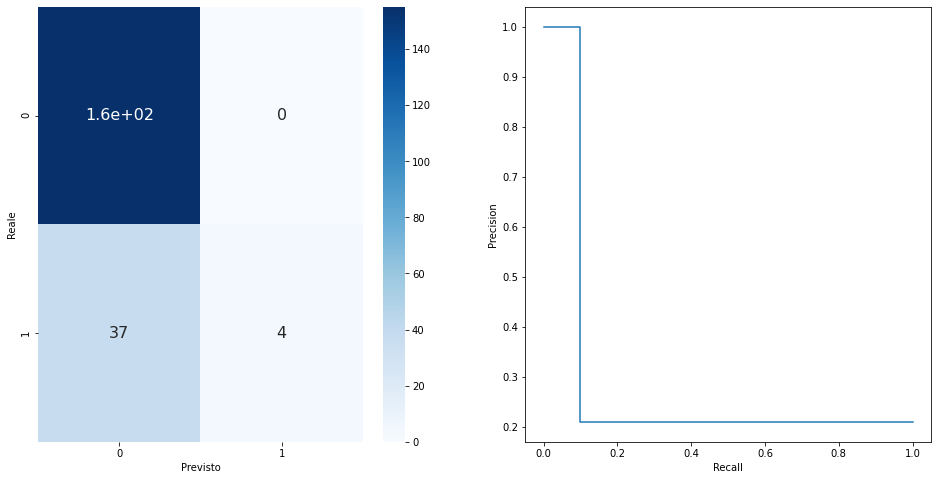

In [132]:
# Norma L2
print_results(ans, True, distance_metric=2)

# Second Floor

In [31]:
df = pd.read_pickle('train1.pkl')
df

,AvgP1,AvgT,AvgH,AvgP2,AvgP3,DateTime,holidays,dayofweek
DateTime,,,,,,,,
2017-02-08 00:00:00,35.0,4.30,94.199997,34.0,87.0,2017-02-08 00:00:00,0,2
2017-02-08 00:15:00,0.0,4.80,94.550003,0.0,0.0,2017-02-08 00:15:00,0,2
2017-02-08 00:30:00,0.0,5.40,94.800003,51.0,0.0,2017-02-08 00:30:00,0,2
2017-02-08 00:45:00,0.0,5.40,94.449997,0.0,83.0,2017-02-08 00:45:00,0,2
2017-02-08 01:00:00,53.0,5.50,94.199997,0.0,0.0,2017-02-08 01:00:00,0,2
...,...,...,...,...,...,...,...,...
2019-04-09 22:45:00,41.0,10.95,83.250000,41.0,65.0,2019-04-09 22:45:00,0,1
2019-04-09 23:00:00,42.0,10.80,84.599998,42.0,68.0,2019-04-09 23:00:00,0,1
2019-04-09 23:15:00,43.0,10.65,86.050003,43.0,72.0,2019-04-09 23:15:00,0,1


In [32]:
params = {'dense_activation': 'swish', 
          'dropout_rate': 0.45, 
          'ensemble': 5, 
          'hidden_unit': 100, 
          'inp_dropout': 0.0, 
          'inp_noise': 0.2, 
          'loss': 'mse', 
          'recurrent': 'lstm', 
          'units': [80, 30, 50]
}

In [33]:
gc.collect()

266297

In [34]:
if HYPERTUNE:
    df_x, df_y = df['AvgP1'].to_numpy(), df['holidays'].to_numpy()
    best = fmin(objective, space, algo=tpe.suggest, max_evals=40)
else:
    best = None
gc.collect()
best

In [35]:
ans = run(df['AvgP1'].to_numpy(), df['holidays'].to_numpy(), params=params)

61824 14112
x_train: (2363, 168, 1)
x_val1: (920, 168, 1)
x_val2: (2482, 168, 1)
x_test: (3547, 168, 1)
Epoch 1/1000
5/5 [==============================] - 9s 2s/step - loss: 0.1719 - mse: 0.1719 - mape: 23569732.0000 - mae: 0.3204 - val_loss: 0.1427 - val_mse: 0.1427 - val_mape: 10931510.0000 - val_mae: 0.2918
Epoch 2/1000
5/5 [==============================] - 2s 479ms/step - loss: 0.1040 - mse: 0.1040 - mape: 29166772.0000 - mae: 0.2673 - val_loss: 0.1054 - val_mse: 0.1054 - val_mape: 18933592.0000 - val_mae: 0.2684
Epoch 3/1000
5/5 [==============================] - 2s 475ms/step - loss: 0.0949 - mse: 0.0949 - mape: 29161888.0000 - mae: 0.2591 - val_loss: 0.1082 - val_mse: 0.1082 - val_mape: 17607972.0000 - val_mae: 0.2687
Epoch 4/1000
5/5 [==============================] - 2s 478ms/step - loss: 0.0941 - mse: 0.0941 - mape: 31761434.0000 - mae: 0.2617 - val_loss: 0.1026 - val_mse: 0.1026 - val_mape: 19716514.0000 - val_mae: 0.2672
Epoch 5/1000
5/5 [==============================] -

5/5 [==============================] - 2s 497ms/step - loss: 0.0215 - mse: 0.0215 - mape: 11278583.0000 - mae: 0.1041 - val_loss: 0.0209 - val_mse: 0.0209 - val_mape: 4199280.5000 - val_mae: 0.0953
Epoch 74/1000
5/5 [==============================] - ETA: 0s - loss: 0.0216 - mse: 0.0216 - mape: 11222911.0000 - mae: 0.1043
Epoch 00074: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
5/5 [==============================] - 2s 496ms/step - loss: 0.0216 - mse: 0.0216 - mape: 11222911.0000 - mae: 0.1043 - val_loss: 0.0209 - val_mse: 0.0209 - val_mape: 4158347.0000 - val_mae: 0.0952
Epoch 75/1000
5/5 [==============================] - 2s 491ms/step - loss: 0.0216 - mse: 0.0216 - mape: 11135931.0000 - mae: 0.1044 - val_loss: 0.0210 - val_mse: 0.0210 - val_mape: 4165591.7500 - val_mae: 0.0953
Epoch 76/1000
5/5 [==============================] - 2s 484ms/step - loss: 0.0215 - mse: 0.0215 - mape: 11193696.0000 - mae: 0.1041 - val_loss: 0.0210 - val_mse: 0.0210 - val_mape: 4182

In [36]:
for metric, val_metric in [('mse', 'val_mse'), ('mse', 'val_mse'), ('mape', 'val_mape')]:
    print(f"{metric.rjust(8)}: {str(round(ans[metric], 3)).rjust(8)} - {str(round(ans[val_metric], 3)).rjust(8)}")

     mse:    0.021 -    0.021
     mse:    0.021 -    0.021
    mape: 11084719.0 - 4064525.25


### Media e covarianza del residuo

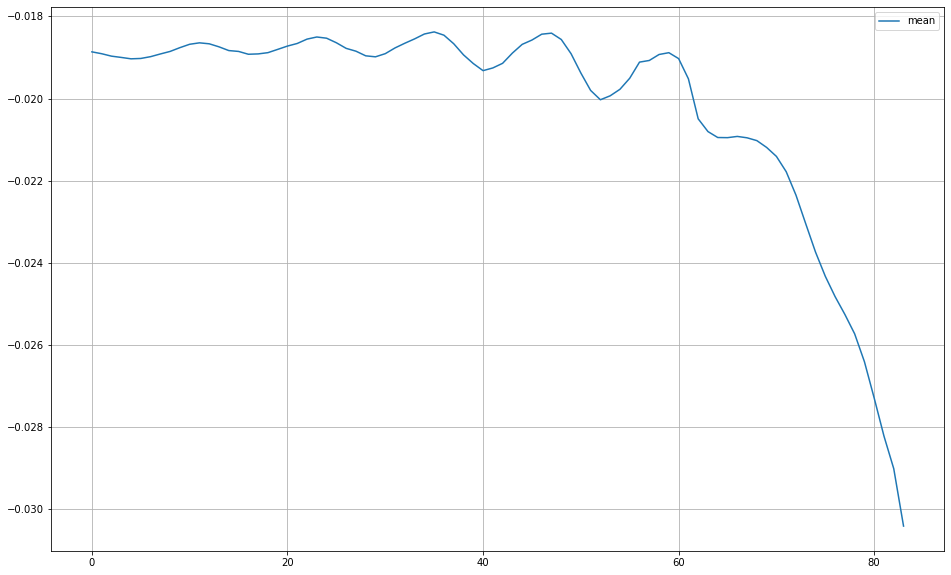

In [37]:
#mean graph
fig, ax = plt.subplots(ncols=1, figsize=FIG_SIZE)
ax.plot(ans['mean'], label=f'mean')
ax.grid()
ax.legend()
plt.show()

rank: 84/84 det: 0.0 min(eigvals): 3.771142656590482e-10


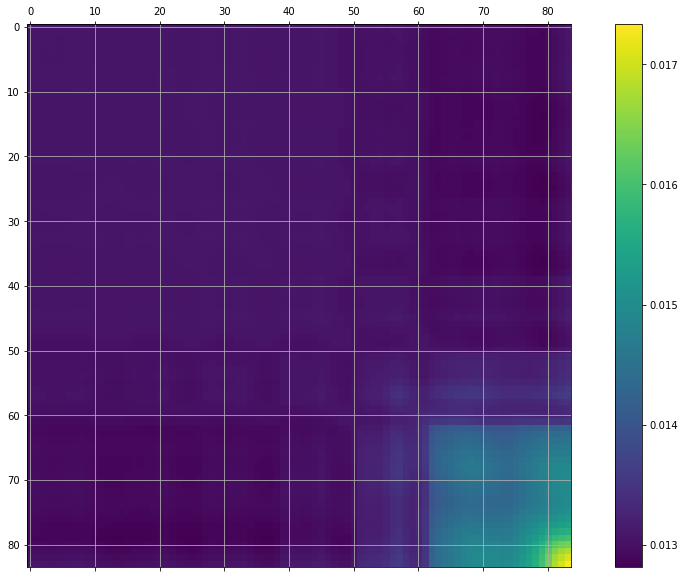

In [38]:
#convariance matrix

print(f'rank: {np.linalg.matrix_rank(ans["cov"])}/{len(ans["cov"])} det: {np.linalg.det(ans["cov"])} min(eigvals): {np.min(np.linalg.eigvals(ans["cov"]))}')

fig, ax = plt.subplots(figsize=FIG_SIZE)
cax = ax.matshow(ans['cov'])
ax.grid()
cbar = fig.colorbar(cax)
plt.show()

### Confronta tra giorni normali e giorni anomali

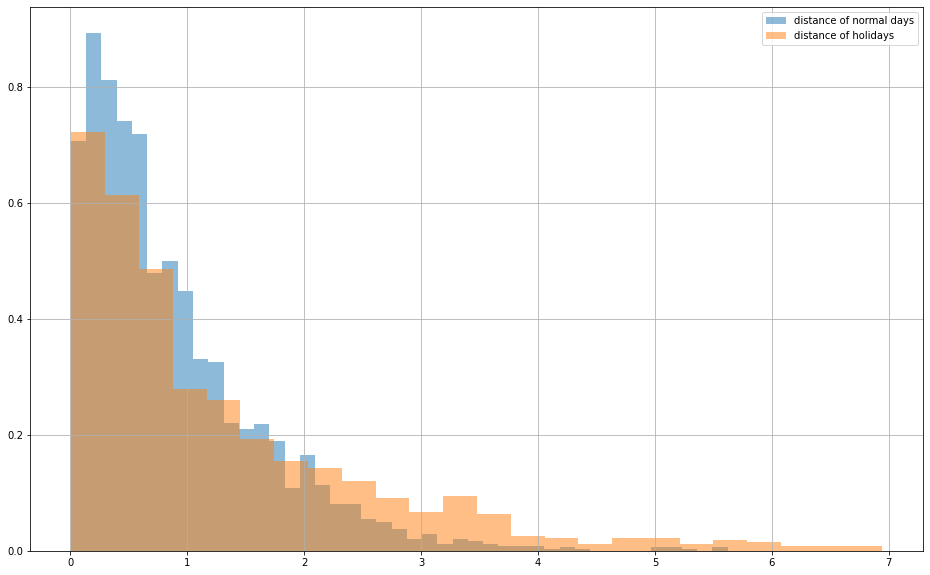

In [39]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
prob_normaldays = np.linalg.norm(ans['res_test'][ans['holidays_test'] == 0], axis=1, ord=2)
prob_holidays = np.linalg.norm(ans['res_test'][ans['holidays_test'] == 1], axis=1, ord=2)

ax.hist(prob_normaldays, label='distance of normal days', bins='auto', density=True, alpha=0.5)
ax.hist(prob_holidays, label='distance of holidays', bins='auto', density=True, alpha=0.5)

ax.grid()
ax.legend()
plt.show()

In [40]:
best_idx = np.argmin(abs(ans['mean']))
best_idx, np.argsort(abs(ans['mean']))

(35,
 array([35, 47, 34, 46, 36, 23, 24, 33, 22, 48, 45, 25, 11, 32, 21, 37, 12,
        10, 44, 20, 13,  9, 31, 26, 19, 14, 27,  8, 15,  0, 18, 59, 43, 30,
        49,  1, 17,  7, 16, 58, 38, 28,  2,  6, 29,  3,  5, 60,  4, 57, 56,
        42, 39, 41, 40, 50, 55, 61, 54, 51, 53, 52, 62, 63, 66, 64, 65, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83],
       dtype=int64))

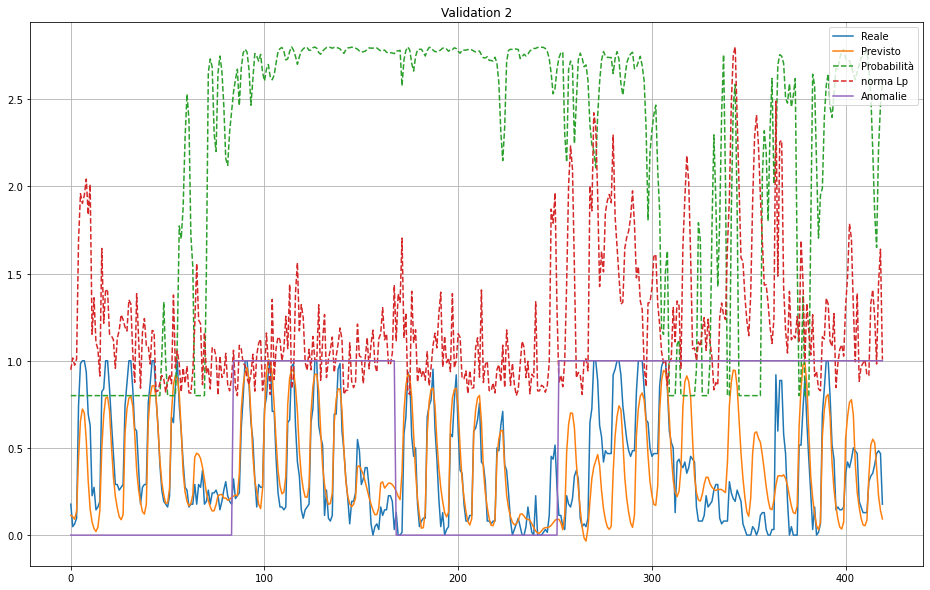

In [41]:
## val2 data
lower = DAY * 0
upper = lower + DAY * 35
pos = ans['cnt_val2'][lower:upper]
fig, ax = plt.subplots(figsize=FIG_SIZE)

ax.plot([i[best_idx] for i in ans['y_val2'][lower:upper]], label='Reale')
ax.plot([i[best_idx] for i in ans['y_val2_pred'][lower:upper]], label='Previsto')

prob = scipy.stats.multivariate_normal.pdf(ans['res_val2'][lower:upper], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob[~np.isfinite(prob)] = 1e300
prob = np.log(prob + 1e-30)
prob_test = prob.copy()

prob = 2 * (prob - prob_test.min()) / (prob_test.max() - prob_test.min())
prob = prob + 0.8
ax.plot(prob, label='Probabilità', linestyle='dashed')

prob = np.linalg.norm(ans['res_val2'][lower:upper], axis=1)
norm_test = prob.copy()
prob = 2 * (prob - norm_test.min()) / (norm_test.max() - norm_test.min())
prob = prob + 0.8
ax.plot(prob, label='norma Lp', linestyle='dashed')


ax.plot(ans['holidays_val2'][lower:upper], label='Anomalie', alpha=1.0)

ax.grid()
ax.legend(loc='upper right')
ax.set_title('Validation 2')
plt.show()

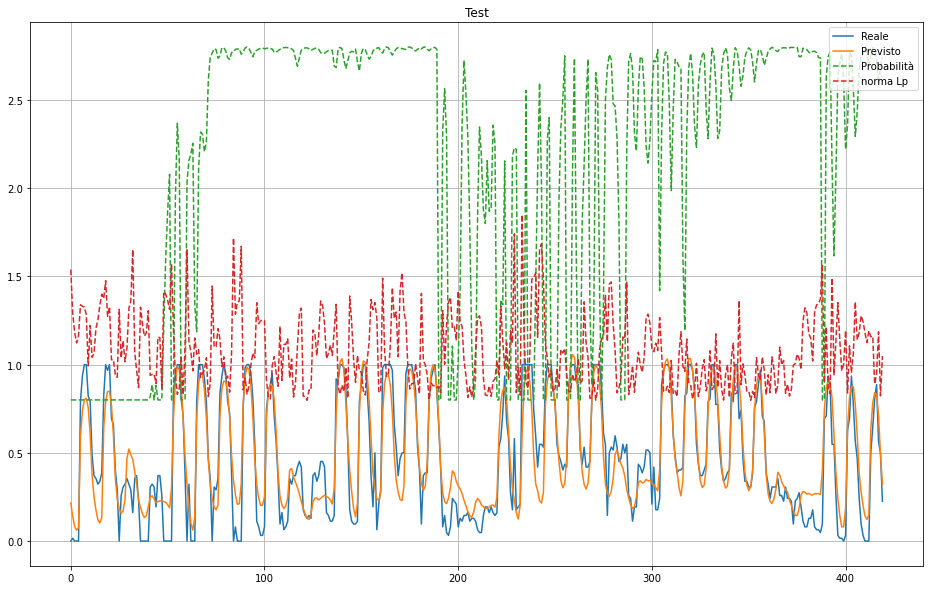

In [42]:
## train data
lower = DAY * 0
upper = lower + DAY * 35
pos = ans['cnt_train'][lower:upper]
fig, ax = plt.subplots(figsize=FIG_SIZE)

ax.plot([i[best_idx] for i in ans['y_train'][lower:upper]], label='Reale')
ax.plot([i[best_idx] for i in ans['y_train_pred'][lower:upper]], label='Previsto')

prob = scipy.stats.multivariate_normal.pdf(ans['res_train'][lower:upper], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob[~np.isfinite(prob)] = 1e300
prob = np.log(prob + 1e-30)

prob = 2 * (prob - prob_test.min()) / (prob_test.max() - prob_test.min())
prob = prob + 0.8
ax.plot(prob, label='Probabilità', linestyle='dashed')

prob = np.linalg.norm(ans['res_train'][lower:upper], axis=1)
prob = 2 * (prob - norm_test.min()) / (norm_test.max() - norm_test.min())
prob = prob + 0.8
ax.plot(prob, label='norma Lp', linestyle='dashed')

ax.grid()
ax.legend(loc='upper right')
ax.set_title('Test')
plt.show()

threshold: 1.9663762606182748e+142 (744/2488) - f0.1: 0.28311142256482136 - f0.1(validation): 0.3687311855505028
{'auc': 0.5262438710714573, 'accuracy': 0.5461689587426326, 'recall': 0.48484848484848486, 'precision': 0.28193832599118945}

              precision    recall  f1-score   support

           0       0.76      0.57      0.65       377
           1       0.28      0.48      0.36       132

    accuracy                           0.55       509
   macro avg       0.52      0.53      0.50       509
weighted avg       0.64      0.55      0.57       509



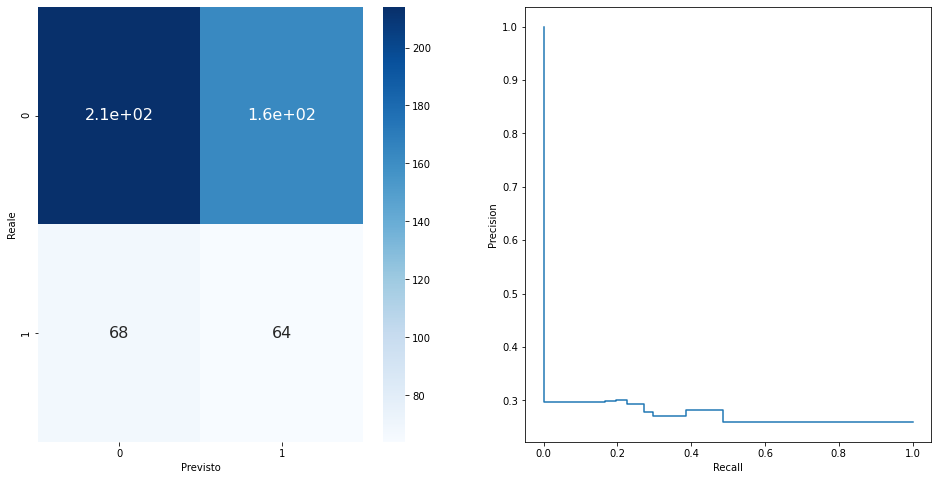

In [43]:
# Probabilità
print_results(ans, True, distance_metric='prob')

threshold: 5.556015240993719 (2455/2488) - f0.1: 0.7829457364341085 - f0.1(validation): 0.8027819175360159
{'auc': 0.5289767703560807, 'accuracy': 0.7544204322200393, 'recall': 0.06060606060606061, 'precision': 0.8888888888888888}

              precision    recall  f1-score   support

           0       0.75      1.00      0.86       377
           1       0.89      0.06      0.11       132

    accuracy                           0.75       509
   macro avg       0.82      0.53      0.49       509
weighted avg       0.79      0.75      0.66       509



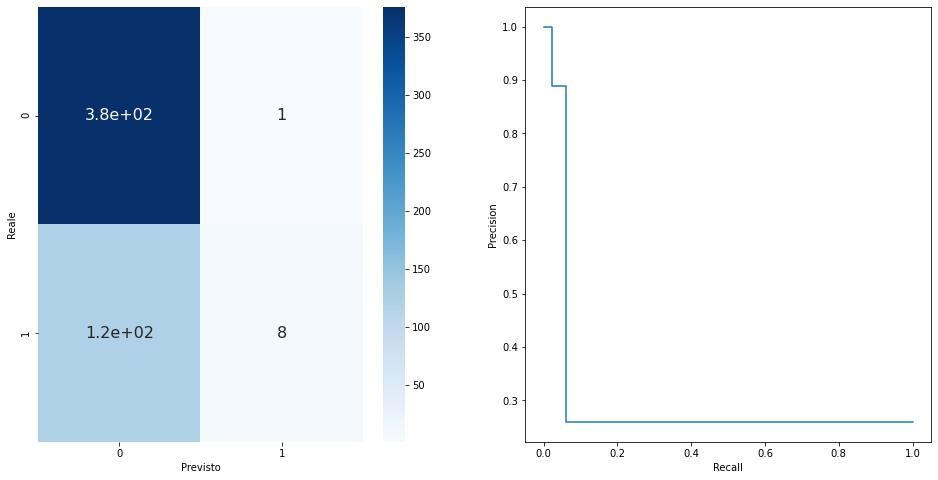

In [44]:
#Norma L2
print_results(ans, True, distance_metric=2)

# Third Floor

In [68]:
df = pd.read_pickle('train1.pkl')

In [89]:
params = {'dense_activation': 'swish', 
          'dropout_rate': 0.1, 
          'ensemble': 4, 
          'hidden_unit': 128, 
          'inp_dropout': 0.0, 
          'inp_noise': 0.2, 
          'loss': 'mse', 
          'recurrent': 'lstm', 
          'units': [140]
}

In [90]:
if HYPERTUNE:
    df_x, df_y = df['AvgP3'].to_numpy(), df['holidays'].to_numpy()
    best = fmin(objective, space, algo=tpe.suggest, max_evals=40)
else:
    best = None
tf.keras.backend.clear_session()
gc.collect()
best

In [91]:
ans = run(df['AvgP3'].to_numpy(), df['holidays'].to_numpy(), params=params)

61824 14112
x_train: (2363, 168, 1)
x_val1: (920, 168, 1)
x_val2: (2482, 168, 1)
x_test: (3547, 168, 1)
Epoch 1/1000
5/5 [==============================] - 4s 831ms/step - loss: 0.1812 - mse: 0.1812 - mape: 35408540.0000 - mae: 0.3154 - val_loss: 0.0847 - val_mse: 0.0847 - val_mape: 21895.7168 - val_mae: 0.2396
Epoch 2/1000
5/5 [==============================] - 2s 361ms/step - loss: 0.0550 - mse: 0.0550 - mape: 38420108.0000 - mae: 0.1942 - val_loss: 0.0624 - val_mse: 0.0624 - val_mape: 20230.4473 - val_mae: 0.2072
Epoch 3/1000
5/5 [==============================] - 2s 339ms/step - loss: 0.0363 - mse: 0.0363 - mape: 20717380.0000 - mae: 0.1508 - val_loss: 0.0461 - val_mse: 0.0461 - val_mape: 17917.5254 - val_mae: 0.1783
Epoch 4/1000
5/5 [==============================] - 2s 339ms/step - loss: 0.0335 - mse: 0.0335 - mape: 23049280.0000 - mae: 0.1457 - val_loss: 0.0303 - val_mse: 0.0303 - val_mape: 20298.9453 - val_mae: 0.1408
Epoch 5/1000
5/5 [==============================] - 2s 340ms

In [92]:
for metric in ['mse', 'val_mse', 'mae', 'val_mae', 'mape', 'val_mape']:
    print(f"{metric.rjust(8)}: {round(np.mean(ans[metric]), 3)} +- {round(np.std(ans[metric]), 3)}")

     mse: 0.021 +- 0.0
 val_mse: 0.023 +- 0.0
     mae: 0.112 +- 0.0
 val_mae: 0.121 +- 0.0
    mape: 14387257.0 +- 0.0
val_mape: 11951.234 +- 0.0


### Media e covarianza del residuo

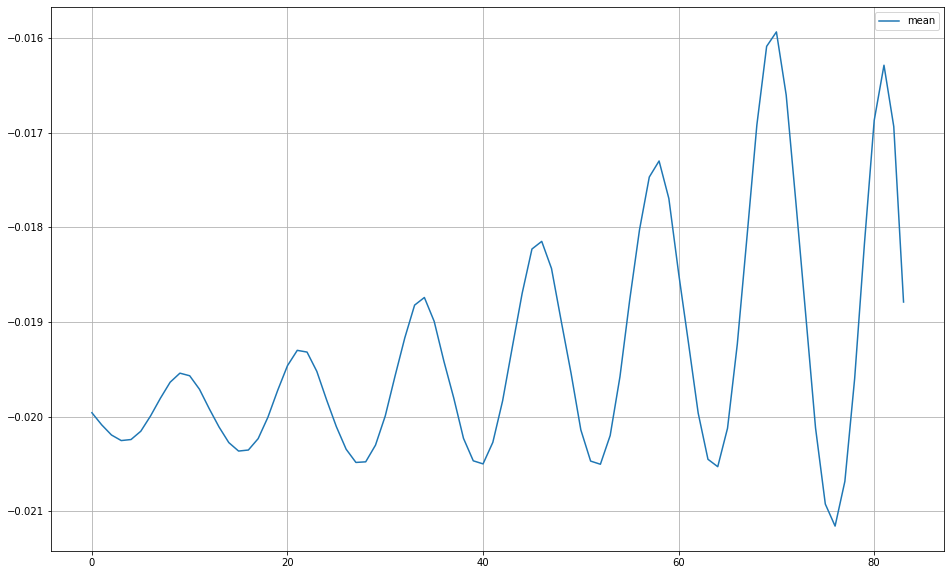

In [93]:
#mean graph
fig, ax = plt.subplots(ncols=1, figsize=FIG_SIZE)
ax.plot(ans['mean'], label=f'mean')
ax.grid()
ax.legend()
plt.show()

rank: 84/84 det: 0.0 min(eigvals): 3.3564592192035154e-10


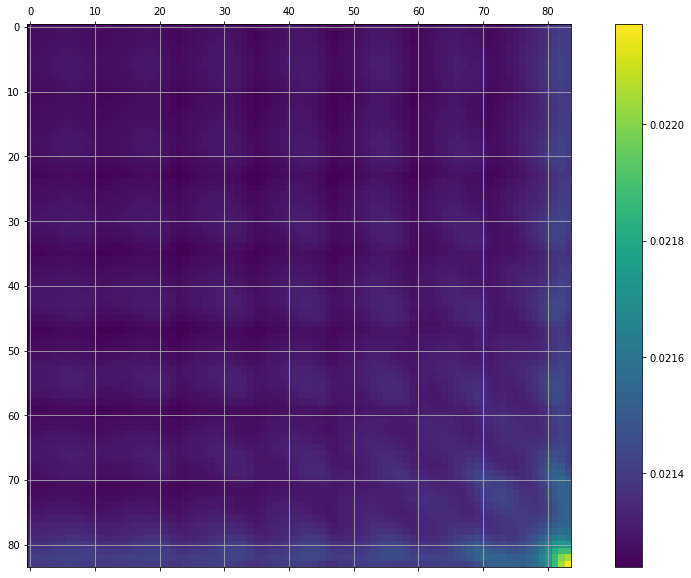

In [94]:
#convariance matrix

print(f'rank: {np.linalg.matrix_rank(ans["cov"])}/{len(ans["cov"])} det: {np.linalg.det(ans["cov"])} min(eigvals): {np.min(np.linalg.eigvals(ans["cov"]))}')

fig, ax = plt.subplots(figsize=FIG_SIZE)
cax = ax.matshow(ans['cov'])
ax.grid()
cbar = fig.colorbar(cax)
plt.show()

### Confronta tra giorni normali e giorni anomali

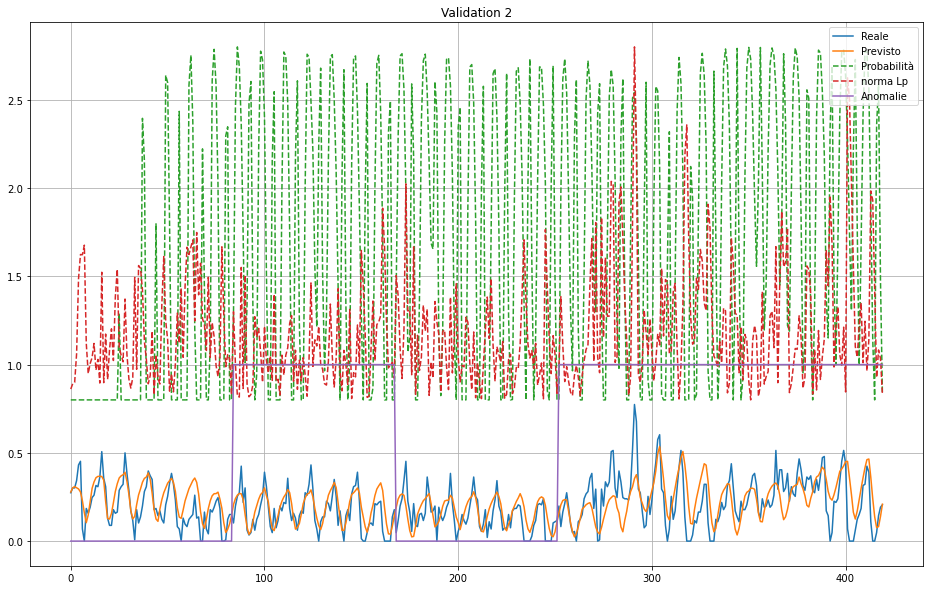

In [95]:
## val2 data
lower = DAY * 0
upper = lower + DAY * 35
pos = ans['cnt_val2'][lower:upper]
fig, ax = plt.subplots(figsize=FIG_SIZE)

ax.plot([i[best_idx] for i in ans['y_val2'][lower:upper]], label='Reale')
ax.plot([i[best_idx] for i in ans['y_val2_pred'][lower:upper]], label='Previsto')

prob = scipy.stats.multivariate_normal.pdf(ans['res_val2'][lower:upper], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob[~np.isfinite(prob)] = 1e300
prob = np.log(prob + 1e-30)
prob_test = prob.copy()

prob = 2 * (prob - prob_test.min()) / (prob_test.max() - prob_test.min())
prob = prob + 0.8
ax.plot(prob, label='Probabilità', linestyle='dashed')

prob = np.linalg.norm(ans['res_val2'][lower:upper], axis=1)
norm_test = prob.copy()
prob = 2 * (prob - norm_test.min()) / (norm_test.max() - norm_test.min())
prob = prob + 0.8
ax.plot(prob, label='norma Lp', linestyle='dashed')


ax.plot(ans['holidays_val2'][lower:upper], label='Anomalie', alpha=1.0)

ax.grid()
ax.legend(loc='upper right')
ax.set_title('Validation 2')
plt.show()

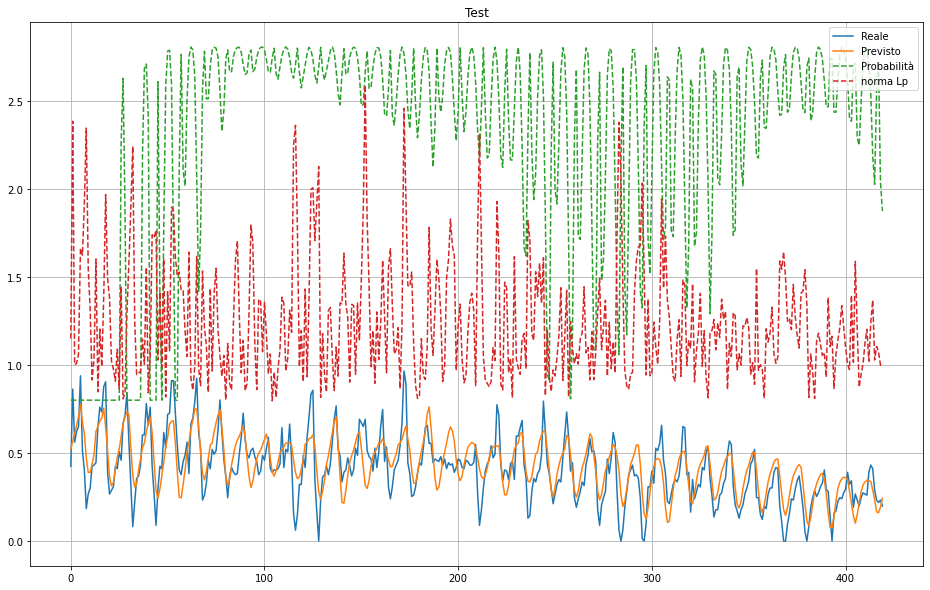

In [96]:
## train data
lower = DAY * 0
upper = lower + DAY * 35
pos = ans['cnt_train'][lower:upper]
fig, ax = plt.subplots(figsize=FIG_SIZE)

ax.plot([i[best_idx] for i in ans['y_train'][lower:upper]], label='Reale')
ax.plot([i[best_idx] for i in ans['y_train_pred'][lower:upper]], label='Previsto')

prob = scipy.stats.multivariate_normal.pdf(ans['res_train'][lower:upper], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob[~np.isfinite(prob)] = 1e300
prob = np.log(prob + 1e-30)

prob = 2 * (prob - prob_test.min()) / (prob_test.max() - prob_test.min())
prob = np.clip(prob, -0.5, 4.0) + 0.8
ax.plot(prob, label='Probabilità', linestyle='dashed')

prob = np.linalg.norm(ans['res_train'][lower:upper], axis=1)
prob = 2 * (prob - norm_test.min()) / (norm_test.max() - norm_test.min())
prob = prob + 0.8
ax.plot(prob, label='norma Lp', linestyle='dashed')


ax.grid()
ax.legend(loc='upper right')
ax.set_title('Test')
plt.show()

threshold: 2.625717182090711e+43 (851/2488) - f0.1: 0.24674267100977199 - f0.1(validation): 0.3428967627791326
{'auc': 0.4838136001929105, 'accuracy': 0.5088408644400786, 'recall': 0.4318181818181818, 'precision': 0.24568965517241378}

              precision    recall  f1-score   support

           0       0.73      0.54      0.62       377
           1       0.25      0.43      0.31       132

    accuracy                           0.51       509
   macro avg       0.49      0.48      0.47       509
weighted avg       0.60      0.51      0.54       509



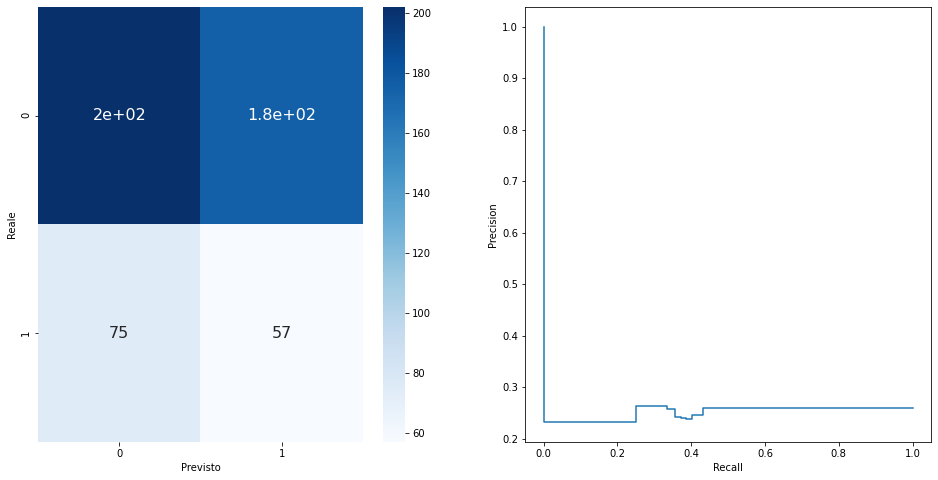

In [97]:
# Probabilità
print_results(ans, True, distance_metric='prob')

threshold: 3.3741441729620196 (2465/2488) - f0.1: 0.21085594989561585 - f0.1(validation): 0.4456701599558743
{'auc': 0.49184149184149184, 'accuracy': 0.6994106090373281, 'recall': 0.06060606060606061, 'precision': 0.21621621621621623}

              precision    recall  f1-score   support

           0       0.74      0.92      0.82       377
           1       0.22      0.06      0.09       132

    accuracy                           0.70       509
   macro avg       0.48      0.49      0.46       509
weighted avg       0.60      0.70      0.63       509



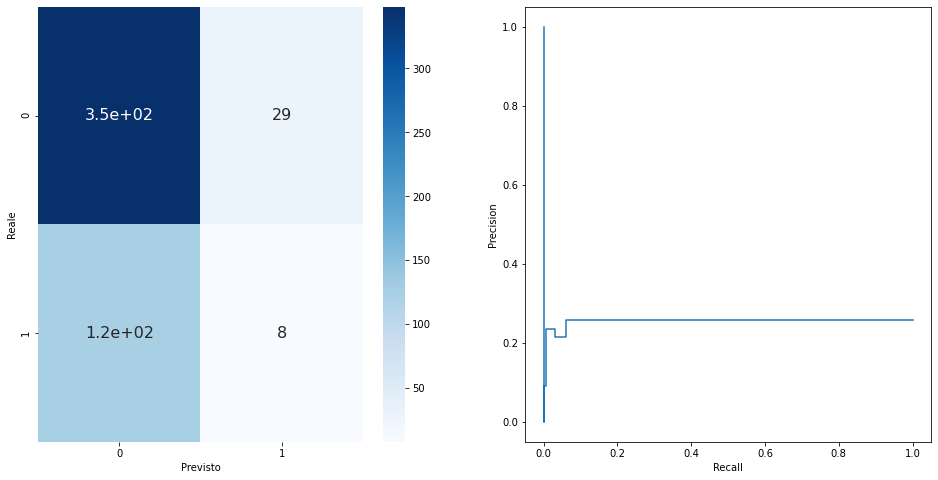

In [98]:
#Norma L2
print_results(ans, True, distance_metric=2)